# Using a CNN on Mel Spectograms to identify COVID-19 from coughs for over 18s only.

Model reads in image files that have been created from cough audio files. Children are excluded from the data.
Machine learning is applied to create a classifier. Oversampling is used to balance the classes by adding duplicates of the minority class samples.

This Model uses ImageDataGenerator

Mounting the Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Upload images to pandas dataframe and visualize a few images.

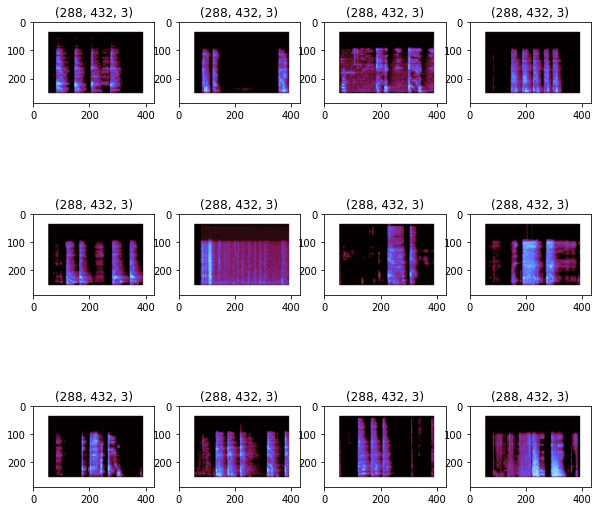

In [2]:
# Always run this code.
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from contextlib import redirect_stdout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve

folder = '/content/drive/My Drive/Colab Notebooks/COVID-19'
if not os.path.exists(folder):
  print(folder + ' does not exist')


df_images = pd.read_csv(os.path.join(folder, 'df_train.csv'), index_col=0)

fnames = df_images.loc[:,'image_file']

plt.figure(figsize=(10,10))
for i in range(12): 
    plt.subplot(3,4,i+1)
    
    filename = fnames[i]
    if not os.path.exists(filename):
      print ('No such file:'+filename)
    
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)
    
plt.show()


In [3]:
pd.set_option('max_columns', None)
print(df_images.shape)
print(df_images.head(5))

(11401, 8)
                                     id   age  gender    status  \
0          Zb2Inq1UVhcMnWA41GpKyRdF4z62  66.0  female   healthy   
1  c4138919-bd2c-4e24-9fcf-582e428c7d27  37.0  female   healthy   
2          ygiPwZYsKFetOejhxWXB6rKSHAf2  66.0    male  COVID-19   
3  ec8ddd1e-d555-490f-9719-70a99c1c6993  29.0    male   healthy   
4          CFkIEzwZ5PcogCElOD2K3RJQzmh1  44.0    male   healthy   

                                          audio_file  \
0  /content/drive/My Drive/Colab Notebooks/coswar...   
1  /content/drive/My Drive/Colab Notebooks/coughv...   
2  /content/drive/My Drive/Colab Notebooks/coswar...   
3  /content/drive/My Drive/Colab Notebooks/coughv...   
4  /content/drive/My Drive/Colab Notebooks/coswar...   

                                          image_file    source  cough_detected  
0  /content/drive/My Drive/Colab Notebooks/coswar...   coswara             NaN  
1  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid          1.0000  
2  /co

Remove under 18s

In [4]:
df_images = df_images.loc[df_images.age >= 18]
print(df_images.shape)
print(df_images.head(5))

(10212, 8)
                                     id   age  gender    status  \
0          Zb2Inq1UVhcMnWA41GpKyRdF4z62  66.0  female   healthy   
1  c4138919-bd2c-4e24-9fcf-582e428c7d27  37.0  female   healthy   
2          ygiPwZYsKFetOejhxWXB6rKSHAf2  66.0    male  COVID-19   
3  ec8ddd1e-d555-490f-9719-70a99c1c6993  29.0    male   healthy   
4          CFkIEzwZ5PcogCElOD2K3RJQzmh1  44.0    male   healthy   

                                          audio_file  \
0  /content/drive/My Drive/Colab Notebooks/coswar...   
1  /content/drive/My Drive/Colab Notebooks/coughv...   
2  /content/drive/My Drive/Colab Notebooks/coswar...   
3  /content/drive/My Drive/Colab Notebooks/coughv...   
4  /content/drive/My Drive/Colab Notebooks/coswar...   

                                          image_file    source  cough_detected  
0  /content/drive/My Drive/Colab Notebooks/coswar...   coswara             NaN  
1  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid          1.0000  
2  /co

## Rearrange the dataset
Split into training set and validation set


In [5]:
# Always run this code.
validation_proportion = 0.3 #Change this if you want to change ratio of validation to training.

num_rows = df_images.shape[0]

df_val = df_images.iloc[:int(validation_proportion*num_rows)]
df_train = df_images.iloc[int(validation_proportion*num_rows):]

print (df_images.shape)
print (df_train.shape)
print (df_val.shape)

print (df_train.head(10))
print (df_val.head(10))

#Check we have a range of images in each set.

print(df_train.groupby('status').status.count())
print(df_val.groupby('status').status.count())

(10212, 8)
(7149, 8)
(3063, 8)
                                        id   age  gender    status  \
3411          PlsyeCq5jHO4E70iZHfrfHSqSJu2  47.0    male   healthy   
3412          6d2och05gaZuhGjLC5rEVdGPSsS2  18.0    male   healthy   
3413          UV965HIG9saPO9HjKNFSm2aFeBt2  27.0    male   healthy   
3414  bf591c70-dba7-4668-b9bf-d11a1ea68b8c  42.0  female   healthy   
3415  1868bb81-0364-4259-a935-b4466a5d8f37  45.0    male   healthy   
3416          f9LON5JU5reyllM213wpaoJqUSu2  68.0  female  COVID-19   
3417  9b61378d-5c61-41ea-8465-f6225ebbf04b  33.0    male   healthy   
3418  34295ae3-37c3-44b8-b3c5-4ab9a002c5eb  27.0    male   healthy   
3419  660f52df-42dc-49e9-ac87-473c6db99d17  30.0    male  COVID-19   
3420  6ea0f6b7-8110-4940-b848-0635be9b5978  29.0    male   healthy   

                                             audio_file  \
3411  /content/drive/My Drive/Colab Notebooks/coswar...   
3412  /content/drive/My Drive/Colab Notebooks/coswar...   
3413  /content/drive/

# Dealing with Imbalanced Dataset

Adding a copy of all COVID-19 images in training dataset to improve the balance of the data - **oversampling**.

In [6]:
#Create dataframe of just covid images from df_train
df_covid = df_train.loc[df_train.status =='COVID-19']
print(df_covid.shape)
print(df_covid.head())

(664, 8)
                                        id   age  gender    status  \
3416          f9LON5JU5reyllM213wpaoJqUSu2  68.0  female  COVID-19   
3419  660f52df-42dc-49e9-ac87-473c6db99d17  30.0    male  COVID-19   
3421          zM5GsorprLYElGQ3uJwnU0g0Fwr1  35.0    male  COVID-19   
3422          bx564wHvi9d0HyJTtdi0haZuU493  28.0    male  COVID-19   
3429          E3nlERKGBPcSO2PjEDJ6GrRKiy73  47.0    male  COVID-19   

                                             audio_file  \
3416  /content/drive/My Drive/Colab Notebooks/coswar...   
3419  /content/drive/My Drive/Colab Notebooks/coughv...   
3421  /content/drive/My Drive/Colab Notebooks/coswar...   
3422  /content/drive/My Drive/Colab Notebooks/coswar...   
3429  /content/drive/My Drive/Colab Notebooks/coswar...   

                                             image_file    source  \
3416  /content/drive/My Drive/Colab Notebooks/coswar...   coswara   
3419  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid   
3421  /c

In [7]:
# Add copies of all COVID-19 images to dataframe df_train
covid = df_train.groupby('status').status.count()[0]
healthy = df_train.groupby('status').status.count()[1]
extra_required = healthy - covid

for i in range (int(extra_required/covid)):
  df_train = pd.concat([df_train,df_covid]) 

new_covid = int(extra_required/covid) * covid + covid

if healthy > new_covid:
  df_train = pd.concat([df_train,df_covid[:(healthy - new_covid)]])

df_train = df_train.sample(frac = 1) #shuffle dataframe
print(df_train.shape)
print(df_train.head())

print(df_train.groupby('status').status.count())

(12970, 8)
                                        id   age  gender    status  \
3629  4e22c07a-17db-4716-b500-f73bb8c86d43  75.0    male   healthy   
7818          YuahWhZmLgMcw3hpc83mcz06bMS2  46.0  female  COVID-19   
4521  6f15d0ed-6550-4543-a77c-7a9bcc97deb2  21.0    male   healthy   
5660  c3cbbb9b-90f8-4bd8-86b1-a7b9cf7ea1e0  43.0    male   healthy   
7721  7b2f0aeb-b301-4719-9cdf-680b05888dc1  34.0    male   healthy   

                                             audio_file  \
3629  /content/drive/My Drive/Colab Notebooks/coughv...   
7818  /content/drive/My Drive/Colab Notebooks/coswar...   
4521  /content/drive/My Drive/Colab Notebooks/coughv...   
5660  /content/drive/My Drive/Colab Notebooks/coughv...   
7721  /content/drive/My Drive/Colab Notebooks/coughv...   

                                             image_file    source  \
3629  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid   
7818  /content/drive/My Drive/Colab Notebooks/coswar...   coswara   
4521  

Create input pipeline using ImageDataGenerator. 

In [8]:
# Always run this code.

batch_size = 100
img_height = 288
img_width = 432

# Rescaling of data moved to first layer of model
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = datagen.flow_from_dataframe(df_train, x_col = "image_file", y_col = "status", 
                                               target_size = (img_height,img_width),  
                                               class_mode = "binary", batch_size = batch_size, 
                                               shuffle = True, validate_filenames = True)

val_data = datagen.flow_from_dataframe(df_val, x_col = "image_file", y_col = "status", 
                                           target_size = (img_height,img_width), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

Found 12970 validated image filenames belonging to 2 classes.
Found 3063 validated image filenames belonging to 2 classes.


# Creating Dataset

In [9]:
# Always run this code.
# Creating Datasets using ImageDatagenerator

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,  
    output_types = (tf.float32 , tf.float32) , # output dtype
    output_shapes = ([None , 288 , 432 , 3] , [None , ]) # The 'None' enables different batch sizes when training.
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: val_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

train_dataset , valid_dataset

(<FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

Need to add cardinality as otherwise the model will not know how many images there are.

In [10]:
# Always run this code.
train_dataset = train_dataset.apply(tf.data.experimental.assert_cardinality(df_train.shape[0])) #Check these numbers with validated files found in data generator section.
valid_dataset = valid_dataset.apply(tf.data.experimental.assert_cardinality(df_val.shape[0]))

len(train_dataset) , len(valid_dataset)

(12970, 3063)

# CNN Network



Although there are built in measures for precision and recall, there are not the equivalent measures of specificity and negative prediction rate so I have had to create custom metrics for those.

I have used example in (tf.keras.metrics.Metric | TensorFlow Core v2.7.0) for Precision
 and changed it to calculate the metrics I need.

In [11]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class Specificity(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(Specificity, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_positives = self.add_weight(
        'false_positives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_positives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_positives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(Specificity, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [12]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class NPV(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(NPV, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_negatives = self.add_weight(
        'false_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_negatives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_negatives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(NPV, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

# **Metrics available for use**

In [13]:
# Always run this cell.
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

# **Fit model on the training dataset**

In [14]:
#Run metrics available cell first to reset metrics
#Run this cell to create model or use next cell to load existing model.
model_name = "Covid_Model_age_1.h5" #Change name here for each new model

model = keras.Sequential([              

    #Rescale the pixel values (integers between 0 and 255) to [0,1]. 
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
    layers.RandomTranslation(height_factor = 0, width_factor = 0.2, fill_mode='nearest'),
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape =[288,432,3]),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Four
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Five
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Six
    layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
])

model._name= model_name[:-3]

model_plots_folder = os.path.join(folder,'model_plots')

# Save model summaries to a text file.
with open(os.path.join(model_plots_folder,'Model_summaries.txt'), 'a') as f:
    with redirect_stdout(f):
        model.summary()

# Save model plots to individual png files.
plot_model(
    model,
    to_file=(os.path.join(model_plots_folder, model_name[:-3] + ".png")),
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

model.summary()
plot_model(model, show_shapes=True)

es_callback = EarlyStopping(monitor = 'val_auc',
                            mode='max',
                            min_delta = 0.01,
                            patience = 10,
                            restore_best_weights = True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 30,
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Model: "Covid_Model_age_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 288, 432, 3)       0         
                                                                 
 random_translation (RandomT  (None, 288, 432, 3)      0         
 ranslation)                                                     
                                                                 
 conv2d (Conv2D)             (None, 288, 432, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 288, 432, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 144, 216, 32)     0         
 )                                                               
                                                 

In [15]:
#Run again with a lower learning rate
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

history1 = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 60,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Epoch 15/60
129/129 [==============================] - 119s 905ms/step - loss: 0.5434 - TP: 4981.0000 - FP: 2285.0000 - FN: 1490.0000 - TN: 4114.0000 - NPV: 0.7341 - specificity: 0.6429 - recall: 0.7697 - auc: 0.7888 - val_loss: 0.7946 - val_TP: 1249.0000 - val_FP: 61.0000 - val_FN: 1478.0000 - val_TN: 175.0000 - val_NPV: 0.1059 - val_specificity: 0.7415 - val_recall: 0.4580 - val_auc: 0.6933
Epoch 16/60
129/129 [==============================] - 114s 884ms/step - loss: 0.5024 - TP: 4997.0000 - FP: 1868.0000 - FN: 1388.0000 - TN: 4617.0000 - NPV: 0.7689 - specificity: 0.7120 - recall: 0.7826 - auc: 0.8297 - val_loss: 0.6369 - val_TP: 1803.0000 - val_FP: 93.0000 - val_FN: 918.0000 - val_TN: 149.0000 - val_NPV: 0.1396 - val_specificity: 0.6157 - val_recall: 0.6626 - val_auc: 0.6947
Epoch 17/60
129/129 [==============================] - 114s 887ms/step - loss: 0.4719 - TP: 5129.0000 - FP: 1671.0000 - FN: 1349.0000 - TN: 4721.0000 - NPV: 0.7778 - specificity: 0.7386 - recall: 0.7918 - auc:

In [16]:
#Run again with a lower learning rate
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

history2 = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 60,
    initial_epoch=history1.epoch[-1],
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Epoch 25/60
129/129 [==============================] - 119s 902ms/step - loss: 0.5140 - TP: 4908.0000 - FP: 1900.0000 - FN: 1508.0000 - TN: 4554.0000 - NPV: 0.7512 - specificity: 0.7056 - recall: 0.7650 - auc: 0.8194 - val_loss: 0.5589 - val_TP: 2059.0000 - val_FP: 105.0000 - val_FN: 675.0000 - val_TN: 124.0000 - val_NPV: 0.1552 - val_specificity: 0.5415 - val_recall: 0.7531 - val_auc: 0.7052
Epoch 26/60
129/129 [==============================] - 115s 891ms/step - loss: 0.5062 - TP: 5019.0000 - FP: 1926.0000 - FN: 1375.0000 - TN: 4550.0000 - NPV: 0.7679 - specificity: 0.7026 - recall: 0.7850 - auc: 0.8275 - val_loss: 0.5738 - val_TP: 2027.0000 - val_FP: 107.0000 - val_FN: 700.0000 - val_TN: 129.0000 - val_NPV: 0.1556 - val_specificity: 0.5466 - val_recall: 0.7433 - val_auc: 0.7036
Epoch 27/60
129/129 [==============================] - 115s 893ms/step - loss: 0.5033 - TP: 5084.0000 - FP: 1962.0000 - FN: 1400.0000 - TN: 4424.0000 - NPV: 0.7596 - specificity: 0.6928 - recall: 0.7841 - auc

In [17]:
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'
model.save(model_folder + model_name)

In [ ]:
#Only run this cell if you want to reload model run previously.
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'

custom_objects = {"NPV": NPV, "Specificity": Specificity}
with keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_folder + "Covid_Model_age_1.h5")

**Plot Training**

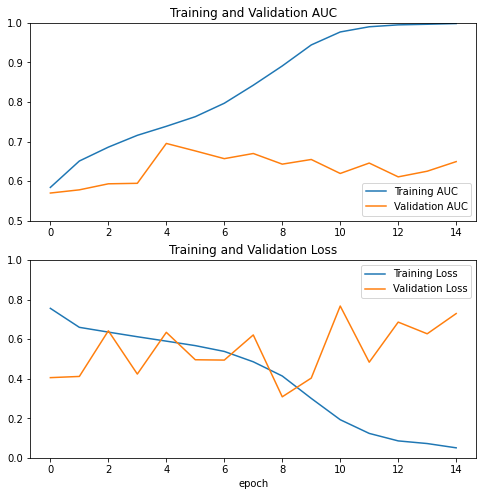

In [18]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

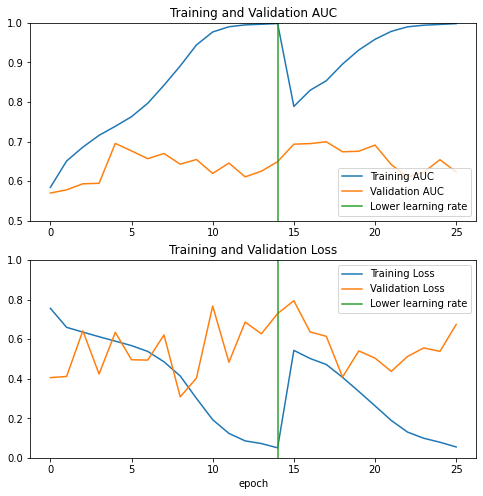

In [19]:
auc += history1.history['auc']
val_auc += history1.history['val_auc']

loss += history1.history['loss']
val_loss += history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([0.5, 1])
plt.plot([history.epoch[-1],history.epoch[-1]],
          plt.ylim(), label='Lower learning rate')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history.epoch[-1],history.epoch[-1]],
         plt.ylim(), label='Lower learning rate')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Apply model to test dataset.**

In [20]:
# Import Test dataframe
df_test = pd.read_csv(os.path.join(folder, 'df_test.csv'), index_col=0)
df_test = df_test.loc[df_test.age >= 18]

#Rescale images in the same way as for train and validation sets
test_data = datagen.flow_from_dataframe(df_test, x_col = "image_file", y_col = "status", 
                                           target_size = (288,432), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

#Create dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

#Assert cardinality so the length can be used.
test_dataset = test_dataset.apply(tf.data.experimental.assert_cardinality(df_test.shape[0]))

Found 893 validated image filenames belonging to 2 classes.


In [21]:
#Test model on test dataset
_,TP,FP,FN,TN, Spec, npv, Recall, AUC = model.evaluate(test_dataset, steps = df_test.shape[0]//batch_size)
print('Confusion Matrix: ', TP, FP, FN, TN)
print('Test NPV: %.4f' % npv)
print('Test Specificity: %.4f' % Spec)
print('Test Recall: %.4f' % Recall)
print('Test ROC-AUC: %.4f' % AUC)

8/8 [==============================] - 364s 45s/step - loss: 0.5602 - TP: 553.0000 - FP: 42.0000 - FN: 164.0000 - TN: 41.0000 - NPV: 0.2000 - specificity: 0.4940 - recall: 0.7713 - auc: 0.6888
Confusion Matrix:  553.0 42.0 164.0 41.0
Test NPV: 0.4940
Test Specificity: 0.2000
Test Recall: 0.7713
Test ROC-AUC: 0.6888
